# DMN and Working Memory in Human Connectome Project (HCP) Dataset

The HCP dataset comprises resting-state and task-based fMRI from a large sample of human subjects. The NMA-curated dataset includes time series data that has been preprocessed and spatially-downsampled by aggregating within 360 regions of interest.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Necessary for visualization
from nilearn import plotting, datasets

# Helper functions
from funcs import utils

# Basic parameters

In [2]:
# The data shared for NMA projects is a subset of the full HCP dataset
N_SUBJECTS = 339

# The data have already been aggregated into ROIs from the Glasesr parcellation
N_PARCELS = 360

# The acquisition parameters for all tasks were identical
TR = 0.72  # Time resolution, in sec

# The parcels are matched across hemispheres with the same order
HEMIS = ["Right", "Left"]

# Each experiment was repeated multiple times in each subject
N_RUNS_REST = 4
N_RUNS_TASK = 2

# Time series data are organized by experiment, with each experiment
# having an LR and RL (phase-encode direction) acquistion
BOLD_NAMES = [
  "rfMRI_REST1_LR", "rfMRI_REST1_RL",
  "rfMRI_REST2_LR", "rfMRI_REST2_RL",
  "tfMRI_MOTOR_RL", "tfMRI_MOTOR_LR",
  "tfMRI_WM_RL", "tfMRI_WM_LR",
  "tfMRI_EMOTION_RL", "tfMRI_EMOTION_LR",
  "tfMRI_GAMBLING_RL", "tfMRI_GAMBLING_LR",
  "tfMRI_LANGUAGE_RL", "tfMRI_LANGUAGE_LR",
  "tfMRI_RELATIONAL_RL", "tfMRI_RELATIONAL_LR",
  "tfMRI_SOCIAL_RL", "tfMRI_SOCIAL_LR"
]

# You may want to limit the subjects used during code development.
# This will use all subjects:
subjects = range(N_SUBJECTS)

# Downloading data

The rest and task data are shared in different files, but they will unpack into the same directory structure.

Each file is fairly large and will take some time to download. If you are focusing only on rest or task analyses, you may not want to download only that dataset.

We also separately provide some potentially useful behavioral covariate information.

In [3]:
# Configuration
DATA_FILES = [
    {"name": "hcp_rest.tgz", "url": "https://osf.io/bqp7m/download"},
    {"name": "hcp_task.tgz", "url": "https://osf.io/s4h8j/download"},
    {"name": "hcp_covariates.tgz", "url": "https://osf.io/x5p4g/download"},
    {"name": "atlas.npz", "url": "https://osf.io/j5kuc/download"}
]

HCP_DIR = Path('..') / 'data'

utils.download_and_extract_data(
    data_dir = HCP_DIR,
    files = DATA_FILES
)

2.79GiB [00:00, 111GiB/s]

Skipping hcp_rest.tgz: File already exists
Skipping hcp_task.tgz: File already exists
Skipping hcp_covariates.tgz: File already exists
Skipping atlas.npz: File already exists
All downloads and extractions completed!


In [11]:
#@title Figure settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")

## Loading region information

Downloading either dataset will create the `regions.npy` file, which contains the region name and network assignment for each parcel.

Detailed information about the name used for each region is provided [in the Supplement](https://static-content.springer.com/esm/art%3A10.1038%2Fnature18933/MediaObjects/41586_2016_BFnature18933_MOESM330_ESM.pdf) to [Glasser et al. 2016](https://www.nature.com/articles/nature18933).

Information about the network parcellation is provided in [Ji et al, 2019](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6289683/).

In [6]:
dir = os.path.join(HCP_DIR, "hcp_task")  # choose the data directory
regions = np.load(os.path.join(dir, "regions.npy")).T
region_info = dict(name=regions[0].tolist(),
                   network=regions[1],
                   myelin=regions[2].astype(float)
                   )
dtype = [('name', 'U16'), ('network', 'U16'), ('myelin', 'f4')]
region_array = np.array(list(zip(region_info['name'], region_info['network'], region_info['myelin'])), dtype=dtype)

ٍExtracting ROIs related to default mode network(Posterior Cingulate Cortex (PCC),
Medial Prefrontal Cortex (mPFC), Angular Gyrus (AG)) and Working Memory Network(Dorsolateral Prefrontal Cortex (DLPFC), Parietal Cortex, Supplementary Motor Area (SMA)):

In [7]:
DMN_REGIONS = region_array[region_array['network'] == 'Default']["name"]
WMN_REGIONS = region_array[region_array['network'] == "Frontopariet"]["name"]
DMN_INDEX = [region_info["name"].index(r) for r in DMN_REGIONS]
WMN_INDEX = [region_info["name"].index(r) for r in WMN_REGIONS]

In [8]:
print(DMN_REGIONS)
print(WMN_REGIONS)
print(set(region_info["network"]))
print(DMN_INDEX)
print(WMN_INDEX)

['R_55b' 'R_PSL' 'R_SFL' 'R_STV' 'R_44' 'R_45' 'R_IFJa' 'R_IFSp' 'R_STGa'
 'R_A5' 'R_STSda' 'R_STSdp' 'R_TPOJ1' 'R_TGv' 'L_55b' 'L_SFL' 'L_45'
 'L_IFJa' 'L_STGa' 'L_A5' 'L_STSdp' 'L_TPOJ1' 'L_TGv']
['R_RSC' 'R_POS2' 'R_7Pm' 'R_8BM' 'R_8C' 'R_a47r' 'R_IFJp' 'R_IFSa'
 'R_p9-46v' 'R_a9-46v' 'R_a10p' 'R_11l' 'R_13l' 'R_i6-8' 'R_s6-8' 'R_AVI'
 'R_TE1p' 'R_IP2' 'R_IP1' 'R_PFm' 'R_p10p' 'R_p47r' 'L_RSC' 'L_POS2'
 'L_7Pm' 'L_33pr' 'L_d32' 'L_8BM' 'L_8C' 'L_44' 'L_a47r' 'L_IFJp' 'L_IFSp'
 'L_p9-46v' 'L_a9-46v' 'L_a10p' 'L_11l' 'L_13l' 'L_OFC' 'L_i6-8' 'L_s6-8'
 'L_AVI' 'L_TE1p' 'L_IP2' 'L_IP1' 'L_PFm' 'L_31a' 'L_p10p' 'L_p47r'
 'L_TE1m']
{np.str_('Dorsal-atten'), np.str_('Frontopariet'), np.str_('Auditory'), np.str_('Posterior-Mu'), np.str_('Somatomotor'), np.str_('Visual2'), np.str_('Default'), np.str_('Ventral-Mult'), np.str_('Orbito-Affec'), np.str_('Visual1'), np.str_('Language'), np.str_('Cingulo-Oper')}
[11, 24, 25, 27, 73, 74, 78, 80, 122, 124, 127, 128, 138, 171, 191, 205, 254, 258, 302

We also provide the [parcellation on the fsaverage5 surface](https://figshare.com/articles/HCP-MMP1_0_projected_on_fsaverage/3498446) and approximate MNI coordinates of each region, which can be useful for visualization:

In [9]:
with np.load(HCP_DIR / 'atlas.npz') as dobj:
  atlas = dict(**dobj)

# Helper functions


## Data loading

In [33]:
def get_image_ids(
    name, 
    bold_names
):
    """Get the 1-based image indices for runs in a given experiment.
    
    Args:
      name (str) : Name of experiment ("rest" or name of task) to load
      bold_names (list[str]) : List of each task acquisition
    Returns:
      run_ids (list of int) : Numeric ID for experiment image files
    
    """
    run_ids = [
             i for i, code in enumerate(bold_names, 1) if name.upper() in code
             ]
    if not run_ids:
        raise ValueError(f"Found no data for '{name}'")
    return run_ids


def load_timeseries(
    subject,
    name,
    data_dir,
    bold_names,
    runs=None,
    concat=True,
    remove_mean=True
):
  """Load timeseries data for a single subject.

  Args:
    subject (int): 0-based subject ID to load
    name (str) : Name of experiment ("rest" or name of task) to load
    data_dir (str) : data directory
    bold_names (list[str]) : List of each task acquisition
    run (None or int or list of ints): 0-based run(s) of the task to load,
      or None to load all runs.
    concat (bool) : If True, concatenate multiple runs in time
    remove_mean (bool) : If True, subtract the parcel-wise mean

  Returns
    ts (n_parcel x n_tp array): Array of BOLD data values

  """
  # Get the list relative 0-based index of runs to use
  if runs is None:
    runs = range(N_RUNS_REST) if name == "rest" else range(N_RUNS_TASK)
  elif isinstance(runs, int):
    runs = [runs]

  # Get the first (1-based) run id for this experiment
  offset = get_image_ids(name, bold_names)[0]

  # Load each run's data
  bold_data = [
               load_single_timeseries(subject,
                                      offset + run,
                                      data_dir,
                                      remove_mean) for run in runs
               ]

  # Optionally concatenate in time
  if concat:
    bold_data = np.concatenate(bold_data, axis=-1)

  return bold_data


def load_single_timeseries(
    subject,
    bold_run,
    data_dir,
    remove_mean=True
):
  """Load timeseries data for a single subject and single run.

  Args:
    subject (int): 0-based subject ID to load
    bold_run (int): 1-based run index, across all tasks
    data_dir (str) : data directory
    remove_mean (bool): If True, subtract the parcel-wise mean

  Returns
    ts (n_parcel x n_timepoint array): Array of BOLD data values

  """
  bold_path = os.path.join(data_dir, "subjects", str(subject), "timeseries")
  bold_file = f"bold{bold_run}_Atlas_MSMAll_Glasser360Cortical.npy"
  ts = np.load(os.path.join(bold_path, bold_file))
  if remove_mean:
    ts -= ts.mean(axis=1, keepdims=True)
  return ts


def load_evs(
    subject, 
    name, 
    bold_names,
    condition, 
    data_dir, 
):
  """Load EV (explanatory variable) data for one task condition.

  Args:
    subject (int): 0-based subject ID to load
    name (str) : Name of task
    bold_names (list[str]) : List of each task acquisition
    condition (str) : Name of condition
    data_dir (str) : data directory

  Returns
    evs (list of dicts): A dictionary with the onset, duration, and amplitude
      of the condition for each run.

  """
  evs = []
  for id in get_image_ids(name, bold_names):
    task_key = bold_names[id - 1]
    ev_file = os.path.join(data_dir, "subjects", str(subject), "EVs",
                           task_key, f"{condition}.txt")
    ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
    ev = dict(zip(["onset", "duration", "amplitude"], ev_array))
    evs.append(ev)
  return evs

# Task analyses

Description of each task, task timing, and conditions is located [here](https://protocols.humanconnectome.org/HCP/3T/task-fMRI-protocol-details.html).

These are the condition names for each task:

```
- MOTOR: cue, lf, lh, rf, rh, t
- WM:
    0bk_body, 0bk_faces, 0bk_nir, 0bk_placed, 0bk_tools,
    2bk_body, 2bk_faces, 2bk_nir, 2bk_placed, 2bk_tools,
    0bk_cor, 0bk_err,
    2bk_cor, 2bk_err,
    all_bk_cor, all_bk_err
- EMOTION: feat, neutral
- GAMBLING: loss, loss_event, win, win_event, neut_event
- LANGUAGE:
    cue,
    math, story
    present_math, present_story,
    question_math, question_story,
    response_math, response_story
- RELATIONAL: error, match, relation
- SOCIAL: mental_resp, mental, other_resp, rnd
```

In [132]:
def condition_frames(run_evs, skip=0):
    """Identify timepoints corresponding to a given condition in each run.
    Args:
        run_evs (list of dicts) : Onset and duration of the event, per run
        skip (int) : Ignore this many frames at the start of each trial, to account
          for hemodynamic lag
    Returns:
        frames_list (list of 1D arrays): Flat arrays of frame indices, per run
    """
    frames_list = []
    for ev in run_evs:
        # Check if the event dictionary is empty
        if not ev:
            continue  # Skip this event and move to the next one

        # Check if 'onset' and 'duration' keys exist
        if 'onset' not in ev or 'duration' not in ev:
            continue  # Skip this event if it doesn't have required keys

        # Determine when trial starts, rounded down
        start = np.floor(ev["onset"] / TR).astype(int)
        # Use trial duration to determine how many frames to include for trial
        duration = np.ceil(ev["duration"] / TR).astype(int)
        # Take the range of frames that correspond to this specific trial
        frames = [s + np.arange(skip, d) for s, d in zip(start, duration)]
        frames_list.append(np.concatenate(frames))
    
    return frames_list


def selective_average(timeseries_data, ev, skip=0):
  """Take the temporal mean across frames for a given condition.

  Args:
    timeseries_data (array or list of arrays): n_parcel x n_tp arrays
    ev (dict or list of dicts): Condition timing information
    skip (int) : Ignore this many frames at the start of each trial, to account
      for hemodynamic lag

  Returns:
    avg_data (1D array): Data averagted across selected image frames based
    on condition timing

  """
  # Ensure that we have lists of the same length
  if not isinstance(timeseries_data, list):
    timeseries_data = [timeseries_data]
  if not isinstance(ev, list):
    ev = [ev]
  if len(timeseries_data) != len(ev):
    raise ValueError("Length of `timeseries_data` and `ev` must match.")

  # Identify the indices of relevant frames
  frames = condition_frames(ev, skip)

  # Select the frames from each image
  selected_data = []
  for run_data, run_frames in zip(timeseries_data, frames):
    run_frames = run_frames[run_frames < run_data.shape[1]]
    selected_data.append(run_data[:, run_frames])

  # Take the average in each parcel
  avg_data = np.concatenate(selected_data, axis=-1).mean(axis=-1)

  return avg_data

## Load individual runs for a given task

Load each subject's data for a specific task, separately for each run:

In [32]:
test = get_image_ids('wm', BOLD_NAMES)

Debugging: name = wm, bold_names = ['rfMRI_REST1_LR', 'rfMRI_REST1_RL', 'rfMRI_REST2_LR', 'rfMRI_REST2_RL', 'tfMRI_MOTOR_RL', 'tfMRI_MOTOR_LR', 'tfMRI_WM_RL', 'tfMRI_WM_LR', 'tfMRI_EMOTION_RL', 'tfMRI_EMOTION_LR', 'tfMRI_GAMBLING_RL', 'tfMRI_GAMBLING_LR', 'tfMRI_LANGUAGE_RL', 'tfMRI_LANGUAGE_LR', 'tfMRI_RELATIONAL_RL', 'tfMRI_RELATIONAL_LR', 'tfMRI_SOCIAL_RL', 'tfMRI_SOCIAL_LR']
Debugging: run_ids = [7, 8]


In [42]:
def calculate_fc(
    timeseries,
    indices
):
    timeseries = timeseries[indices, :]
    correlation_matrix = np.corrcoef(timeseries)
    return correlation_matrix


def plot_connectivity_matrix(matrix, title):
    plt.figure(figsize=(8, 8))
    plt.imshow(matrix, vmin=-1, vmax=1, cmap='coolwarm')
    plt.colorbar()
    plt.title(title)
    plt.show()

In [60]:
help(load_evs)

Help on function load_evs in module __main__:

load_evs(subject, name, bold_names, condition, data_dir)
    Load EV (explanatory variable) data for one task condition.

    Args:
      subject (int): 0-based subject ID to load
      name (str) : Name of task
      bold_names (list[str]) : List of each task acquisition
      condition (str) : Name of condition
      data_dir (str) : data directory

    Returns
      evs (list of dicts): A dictionary with the onset, duration, and amplitude
        of the condition for each run.



In [146]:
def get_task_timeseries(
    subject,
    name,
    bold_names,
    data_dir
):
    timeseries = load_timeseries(
        subject=subject,
        name=name,
        bold_names=bold_names,
        data_dir=data_dir,
        concat=False
    )
    return timeseries

timeseries_task = []
corr_matrices = []

for subject in subjects:
    # Get the full timeseries for the working memory task
    timeseries = get_task_timeseries(
        subject=subject,
        name="wm",
        bold_names=BOLD_NAMES,
        data_dir=HCP_DIR / "hcp_task"
    )
    
    # Get the frames for 2-back correct and error trials
    evs_cor = load_evs(
        subject=subject,
        name="wm",
        bold_names=BOLD_NAMES,
        condition="2bk_cor",
        data_dir=HCP_DIR / "hcp_task"
    )
    evs_err = load_evs(
        subject=subject,
        name="wm",
        bold_names=BOLD_NAMES,
        condition="2bk_err",
        data_dir=HCP_DIR / "hcp_task"
    )
    
    frames_cor = condition_frames(evs_cor)
    frames_err = condition_frames(evs_err)

    # Combine correct and error frames
    frames_2back = []
    for fc, fe in zip(frames_cor, frames_err):
        combined = sorted(set(fc.tolist() + fe.tolist()))
        frames_2back.append(np.array(combined))
    
    # Extract all 2-back trials from the full timeseries
    timeseries_2back = []
    for run_data, run_frames in zip(timeseries, frames_2back):
        timeseries_2back.append(run_data[:, run_frames])
    
    # Average the timeseries from both runs
    timeseries_2back = np.mean(timeseries_2back, axis=0)
    
    # Calculate functional connectivity
    fc = calculate_fc(timeseries_2back, np.arange(0, 360))
    corr_matrices.append(fc)
    
    # Store the timeseries if needed
    timeseries_task.append(timeseries_2back)

/tmp/ipykernel_70811/2567195142.py:123: UserWarning: loadtxt: input contained no data: "../data/hcp_task/subjects/1/EVs/tfMRI_WM_LR/2bk_err.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (2, 360) + inhomogeneous part.

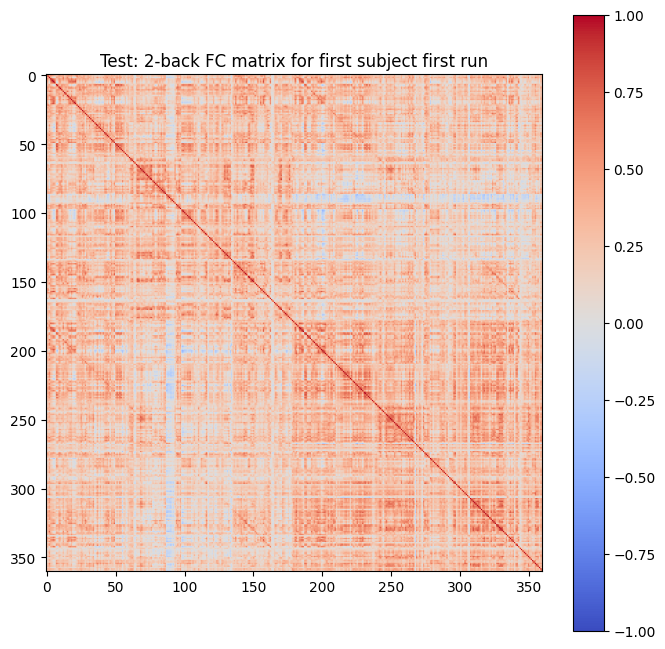

In [78]:
plot_connectivity_matrix(corr_matrices[1], 'Test: 2-back FC matrix for first subject first run')

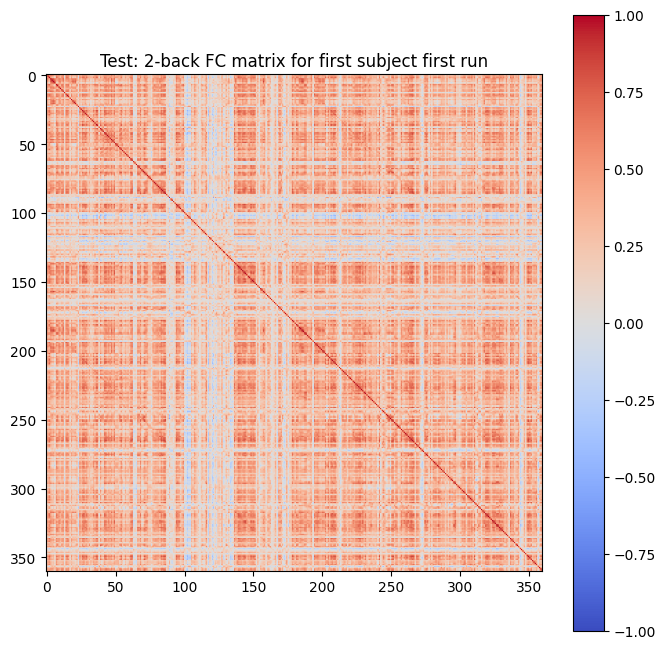

In [81]:
plot_connectivity_matrix(corr_matrices[1], 'Test: 2-back FC matrix for first subject first run')

# Resting-state analyses

Load a single run of resting-state data:

In [26]:
help(load_timeseries)

Help on function load_timeseries in module __main__:

load_timeseries(subject, name, data_dir, runs=None, concat=True, remove_mean=True)
    Load timeseries data for a single subject.

    Args:
      subject (int): 0-based subject ID to load
      name (str) : Name of experiment ("rest" or name of task) to load
      data_dir (str) : data directory
      run (None or int or list of ints): 0-based run(s) of the task to load,
        or None to load all runs.
      concat (bool) : If True, concatenate multiple runs in time
      remove_mean (bool) : If True, subtract the parcel-wise mean

    Returns
      ts (n_parcel x n_tp array): Array of BOLD data values



In [38]:
timeseries = load_timeseries(subject=0,
                             name="wm",
                             bold_names=BOLD_NAMES,
                             data_dir=os.path.join(HCP_DIR, "hcp_task"),
                             runs=1)
print(timeseries.shape)  # n_parcel x n_timepoint

(360, 405)


Load a concatenated resting-state timeseries (using all runs' data) for each subject:

In [41]:
def create_timeseries(subjects, task, repo):
  timeseries = []
  for subject in subjects:
    ts_concat = load_timeseries(subject, name=task,
                                dir=os.path.join(HCP_DIR, repo))
    timeseries.append(ts_concat)
  return timeseries

Computing timeseries for all subjects during working memory task and resting state, to plot functional connectivity of DMN and WMN:

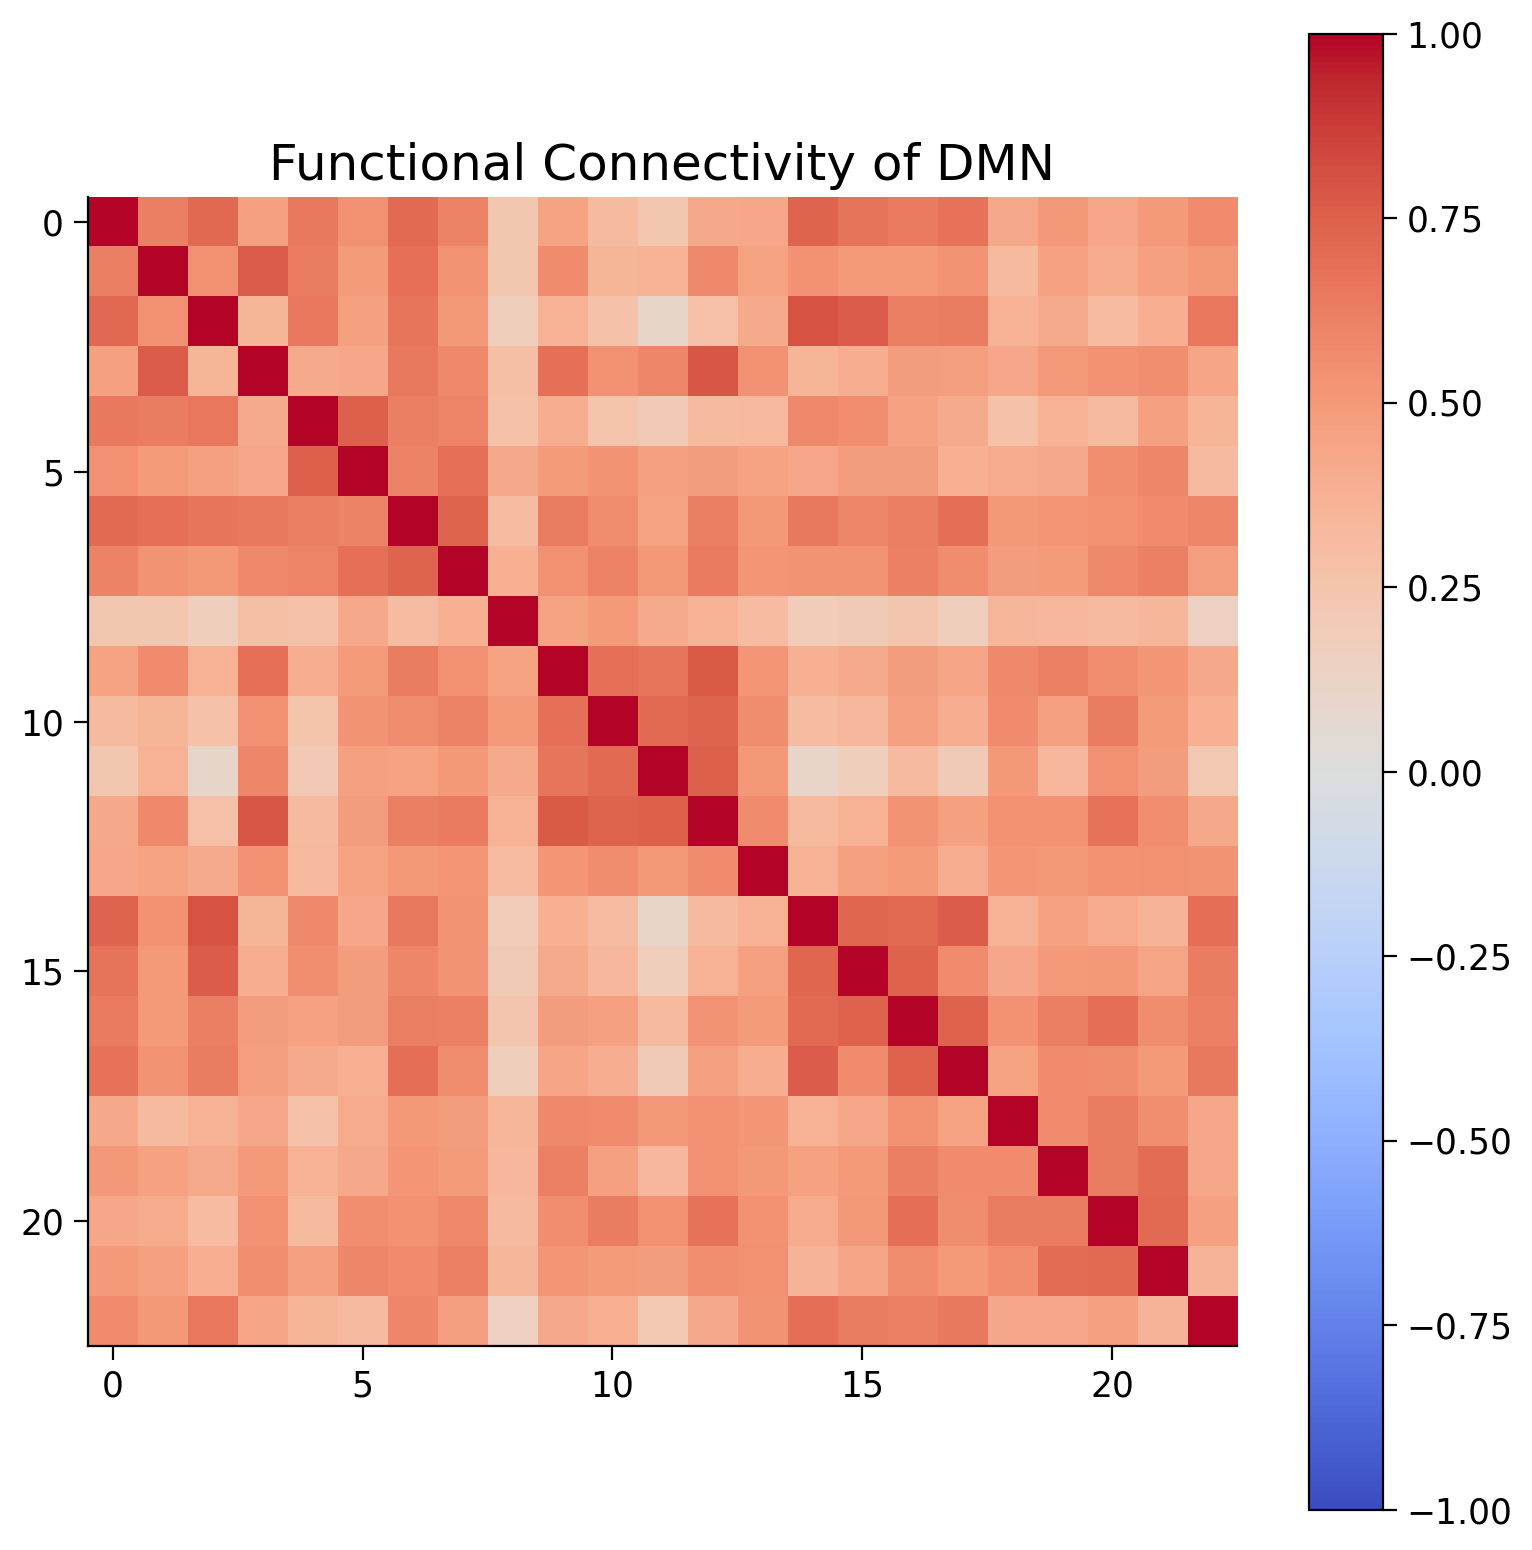

In [48]:
subject = 0
timeseries_rest = load_timeseries(
    subject,
    name = "rest",
    bold_names = BOLD_NAMES,
    data_dir = HCP_DIR / "hcp_rest")
timeseries_wm = load_timeseries(
    subject,
    name = "wm",
    bold_names = BOLD_NAMES,
    data_dir = HCP_DIR / "hcp_task")

fc_dmn = calculate_fc(timeseries_rest, DMN_INDEX)
fc_wmn = calculate_fc(timeseries_rest, WMN_INDEX)

plot_connectivity_matrix(fc_dmn, "Functional Connectivity of DMN")